Step 1 
- Loaded and explored Jigsaw train.csv and all_data.csv (sample)
- Analyzed toxicity label distribution and comment lengths
- Added a binary toxic label for simplified classification
- Identified real ambiguous and obfuscated words for later use

In [90]:
# 📦 Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styles
sns.set(style="whitegrid")
%matplotlib inline

 Load the Primary Dataset (train.csv)

In [91]:
# Load main Jigsaw Toxic dataset
train_df = pd.read_csv("data/train.csv")

# Show first few rows
print("Sample rows from train.csv:")
display(train_df.head())

# Show label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("Toxic label columns:", label_cols)

Sample rows from train.csv:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Toxic label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Label Distribution (Multi-label)

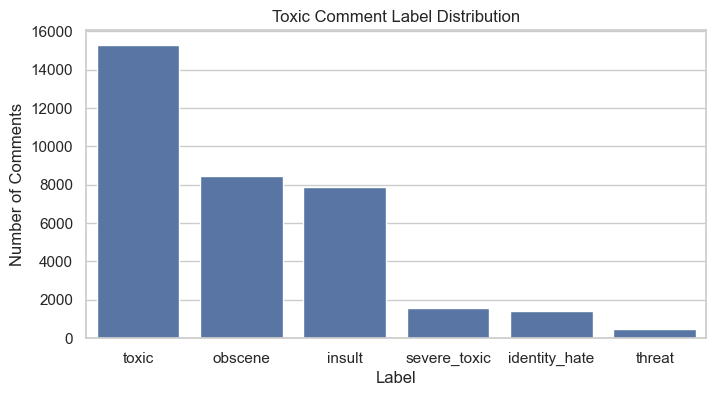

In [92]:
# Sum across label columns
label_counts = train_df[label_cols].sum().sort_values(ascending=False)

# Barplot of label frequencies
plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Toxic Comment Label Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Comments")
plt.show()

Convert to Binary Toxic Label

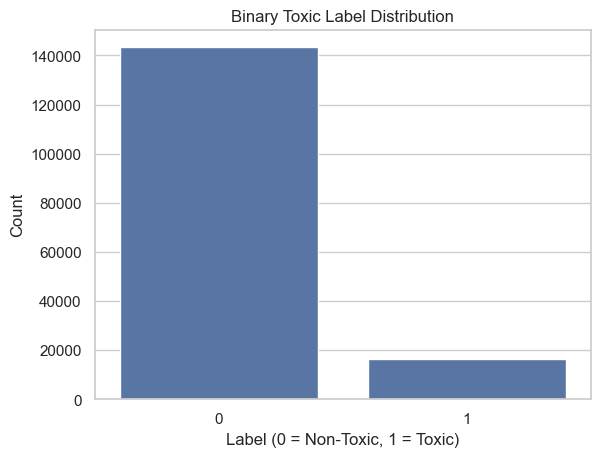

toxic_binary
0    143346
1     16225
Name: count, dtype: int64

In [93]:
# Add a binary label: toxic if any of the labels are 1
train_df['toxic_binary'] = (train_df[label_cols].sum(axis=1) > 0).astype(int)

# Distribution of binary label
sns.countplot(x='toxic_binary', data=train_df)
plt.title("Binary Toxic Label Distribution")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Count")
plt.show()


# Show the count of toxic vs non-toxic comments
train_df['toxic_binary'].value_counts()

Comment Length Analysis

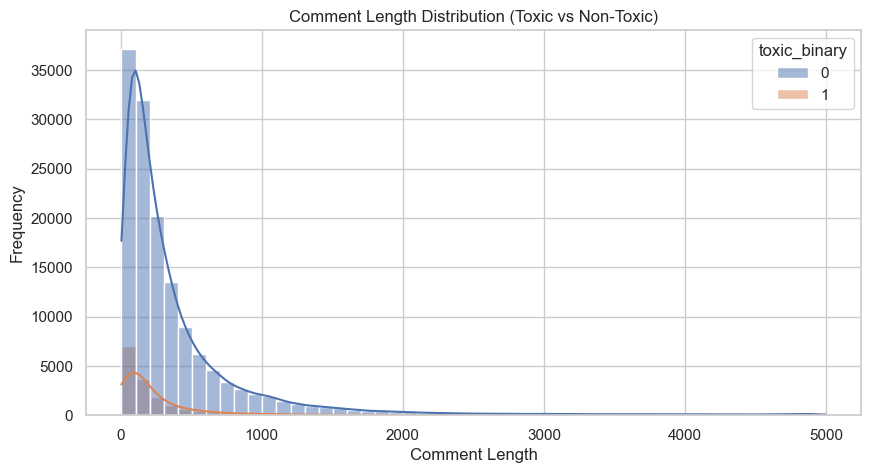

In [94]:
# Create a length feature
train_df['text_length'] = train_df['comment_text'].apply(len)

# Plot comment lengths by toxicity
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='text_length', hue='toxic_binary', bins=50, kde=True)
plt.title("Comment Length Distribution (Toxic vs Non-Toxic)")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.show()

Ambiguous Words in Clean vs Toxic Context

In [95]:
# Words that often get flagged inappropriately
ambiguous_words = ['pussy', 'bitch', 'kill', 'bomb', 'gay']

for word in ambiguous_words:
    toxic_count = train_df[(train_df['toxic_binary'] == 1) & (train_df['comment_text'].str.contains(word, case=False))].shape[0]
    non_toxic_count = train_df[(train_df['toxic_binary'] == 0) & (train_df['comment_text'].str.contains(word, case=False))].shape[0]
    print(f"'{word}' — Toxic: {toxic_count} | Non-Toxic: {non_toxic_count}")

'pussy' — Toxic: 157 | Non-Toxic: 20
'bitch' — Toxic: 849 | Non-Toxic: 60
'kill' — Toxic: 442 | Non-Toxic: 1631
'bomb' — Toxic: 55 | Non-Toxic: 390
'gay' — Toxic: 570 | Non-Toxic: 432


Load Jigsaw Unintended Bias Dataset (Sampled) - (Optional) can be used in later steps.

In [96]:
# Load a sample of the unintended bias dataset
bias_df = pd.read_csv("data/all_data.csv", nrows=100000)

# Show sample rows
print("Sample rows from all_data.csv (Unintended Bias):")
display(bias_df[['comment_text', 'toxicity']].head())

# Convert toxicity score to binary
bias_df['toxic_binary'] = (bias_df['toxicity'] > 0.5).astype(int)

# Check for Obfuscated Terms in Real-world Samples

# Look for obfuscated toxic words in bias dataset
obfuscated_terms = ['k1ll', 'b!tch', '@sshole', 'f@ggot', 'idi0t']

for word in obfuscated_terms:
    matches = bias_df[bias_df['comment_text'].str.contains(word, case=False)]
    print(f"'{word}' found in {matches.shape[0]} comments in all_data.csv")

Sample rows from all_data.csv (Unintended Bias):


,comment_text,toxicity
0,He got his money... now he lies in wait till a...,0.373134
1,Mad dog will surely put the liberals in mental...,0.605263
2,And Trump continues his lifelong cowardice by ...,0.666667
3,"""while arresting a man for resisting arrest"".\...",0.815789
4,Tucker and Paul are both total bad ass mofo's.,0.550000


'k1ll' found in 0 comments in all_data.csv
'b!tch' found in 1 comments in all_data.csv
'@sshole' found in 0 comments in all_data.csv
'f@ggot' found in 0 comments in all_data.csv
'idi0t' found in 3 comments in all_data.csv


Step 2
- Cleaned and preprocessed the text
- Created binary labels for toxicity
- Tokenized text using BERT tokenizer
- Split data into train, val, test
- Created 3 special evaluation sets:
  • ambiguous_validation_df
  • balanced_validation_df
  • adversarial_test_df
- Wrapped all into PyTorch Datasets and DataLoaders

In [97]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Show the count of toxic vs non-toxic comments
train_df['toxic_binary'].value_counts()

toxic_binary
0    143346
1     16225
Name: count, dtype: int64

In [98]:
# Define a function to clean text while keeping obfuscated symbols
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z0-9\s@#$%&*!?]', '', text)  # Keep common obfuscation symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# Apply cleaning
train_df['clean_text'] = train_df['comment_text'].astype(str).apply(clean_text)
for i in range(3):
    print(f"Original: {train_df['comment_text'][i]}")
    print(f"Cleaned:  {train_df['clean_text'][i]}")
    print("-" * 80)
train_df[['comment_text', 'clean_text']].head()

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned:  explanation why the edits made under my username hardcore metallica fan were reverted? they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now892053827
--------------------------------------------------------------------------------
Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned:  daww! he matches this background colour im seemingly stuck with thanks talk 2151 january 11 2016 utc
--------------------------------------------------------------------------------
Original: Hey man, I'm really not trying to edit war. It's just

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww! he matches this background colour im see...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


Load the BERT tokenizer (bert-base-uncased)

In [103]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Split Datasets

In [100]:
from sklearn.model_selection import train_test_split

# 80% Train, 10% Validation, 10% Test
train_df, temp_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['toxic_binary'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['toxic_binary'],
    random_state=42
)

# Show counts for each set
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 127656
Validation: 15957
Test: 15958


Create Special Evaluation Sets

In [104]:
# Define common ambiguous terms that often cause false positives
ambiguous_words = ['pussy', 'bitch', 'gay', 'kill', 'bomb']

# Filter val_df to get samples containing any ambiguous term
def contains_ambiguous(text):
    return any(word in text for word in ambiguous_words)

# Apply filter to validation set
ambiguous_validation_df = val_df[val_df['clean_text'].apply(contains_ambiguous)]

print(f" ambiguous_validation_df created with {len(ambiguous_validation_df)} samples.")

 ambiguous_validation_df created with 436 samples.


In [112]:
# Count available samples in each class
num_toxic = val_df[val_df['toxic_binary'] == 1].shape[0]
num_non_toxic = val_df[val_df['toxic_binary'] == 0].shape[0]

# Choose the smaller count
sample_size = min(num_toxic, num_non_toxic)

# Sample equally from both classes
toxic_samples = val_df[val_df['toxic_binary'] == 1].sample(n=sample_size, random_state=42)
non_toxic_samples = val_df[val_df['toxic_binary'] == 0].sample(n=sample_size, random_state=42)

# Combine and shuffle
balanced_validation_df = pd.concat([toxic_samples, non_toxic_samples]).sample(frac=1, random_state=42)

print(f"✅ Balanced validation set created with {len(balanced_validation_df)} samples (Toxic: {sample_size}, Non-Toxic: {sample_size})")

✅ Balanced validation set created with 3244 samples (Toxic: 1622, Non-Toxic: 1622)


In [106]:
# Load a sample of unintended bias dataset
bias_df = pd.read_csv("data/all_data.csv", usecols=['comment_text', 'toxicity'], nrows=100000)
bias_df['toxic_binary'] = (bias_df['toxicity'] > 0.5).astype(int)

# Obfuscated term filter
obfuscated_terms = ['k1ll', 'b!tch', '@sshole', 'f@ggot', 'idi0t']

def contains_obfuscated(text):
    return any(term in text.lower() for term in obfuscated_terms)

adversarial_test_df = bias_df[bias_df['comment_text'].apply(contains_obfuscated)]
print(f"Adversarial test set: {len(adversarial_test_df)} samples")

Adversarial test set: 4 samples


Tokenization Helper and PyTorch Dataset

In [ ]:
# Tokenization helper function
def tokenize_text(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Tokenize one sample at a time (faster and memory-safe)
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}  # remove batch dim
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# # Custom PyTorch Dataset
# class ToxicDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=128):
#         self.encodings = tokenize_text(texts, tokenizer, max_len)
#         self.labels = torch.tensor(labels.values, dtype=torch.long)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         item['labels'] = self.labels[idx]
#         return item

In [115]:
# Batch size for all loaders
BATCH_SIZE = 16

# Datasets
train_dataset = ToxicDataset(train_df['clean_text'], train_df['toxic_binary'], tokenizer)
val_dataset = ToxicDataset(val_df['clean_text'], val_df['toxic_binary'], tokenizer)
test_dataset = ToxicDataset(test_df['clean_text'], test_df['toxic_binary'], tokenizer)

fp_dataset = ToxicDataset(ambiguous_validation_df['clean_text'], ambiguous_validation_df['toxic_binary'], tokenizer)
balanced_val_dataset = ToxicDataset(balanced_validation_df['clean_text'], balanced_validation_df['toxic_binary'], tokenizer)
adversarial_test_dataset = ToxicDataset(adversarial_test_df['comment_text'], adversarial_test_df['toxic_binary'], tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

fp_loader = DataLoader(fp_dataset, batch_size=BATCH_SIZE)
balanced_val_loader = DataLoader(balanced_val_dataset, batch_size=BATCH_SIZE)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=BATCH_SIZE)

print("✅ All DataLoaders are ready.")

✅ All DataLoaders are ready.


In [ ]:
# # Helper function to peek into one batch
# def print_batch(loader, name):
#     print(f"\n📦 First batch from {name}:")
#     batch = next(iter(loader))
#     print("input_ids shape:", batch['input_ids'].shape)
#     print("attention_mask shape:", batch['attention_mask'].shape)
#     print("labels shape:", batch['labels'].shape)

# # Print batch shapes
# print_batch(train_loader, "train_loader")
# print_batch(val_loader, "val_loader")
# print_batch(test_loader, "test_loader")

# print_batch(fp_loader, "fp_loader (ambiguous)")
# print_batch(balanced_val_loader, "balanced_val_loader (balanced)")
# print_batch(adversarial_test_loader, "adversarial_test_loader (obfuscated)")


print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Ambiguous Validation Set Size: {len(fp_dataset)}")
print(f"Balanced Validation Set Size: {len(balanced_val_dataset)}")
print(f"Adversarial Test Set Size: {len(adversarial_test_dataset)}")



Train Dataset Size: 127656
Validation Dataset Size: 15957
Test Dataset Size: 15958
Ambiguous Validation Set Size: 436
Balanced Validation Set Size: 3244
Adversarial Test Set Size: 4
